In [105]:
import time
start = time.perf_counter()

In [106]:
import datetime as datetime
import pandas as pd
import json
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime,timedelta
import numpy as np
from json import JSONDecodeError
from statsmodels.distributions.empirical_distribution import ECDF
from shapely.geometry import Point, Polygon

In [107]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

## Create Clean status data set based status & trips

### Loading

In [108]:
status_raw = pd.read_csv(r'C:\Users\aviyaoh\Downloads\Aviya Ohayon\Populus Data\2025-02_Status.csv')
trips = pd.read_csv(r'C:\Users\aviyaoh\Downloads\Aviya Ohayon\Populus Data\2025-02_Trips.csv')

#duplicated
trips_check = trips
status_raw_check = status_raw

In [109]:
#status_raw_check['event_types'].unique()

In [110]:
initial_rec_status_raw = len(status_raw)
initial_rec_trips = len(trips)
print(f"initial_rec_status_raw: {initial_rec_status_raw}, initial_rec_trips: {initial_rec_trips}")

initial_rec_status_raw: 1661064, initial_rec_trips: 596581


In [111]:
print(trips_check.columns)

print(trips_check['route'].iloc[0])

Index(['provider_id', 'provider_name', 'vehicle_type', 'propulsion_types',
       'device_id', 'vehicle_id', 'trip_id', 'trip_duration', 'trip_distance',
       'start_time', 'end_time', 'accuracy', 'route', 'mds_version'],
      dtype='object')
{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'properties': {'timestamp': 1738360228799}, 'geometry': {'type': 'Point', 'coordinates': [34.7748375, 32.06596756666667]}}, {'type': 'Feature', 'properties': {'timestamp': 1738360229000}, 'geometry': {'type': 'Point', 'coordinates': [34.7748375, 32.06596756666667]}}, {'type': 'Feature', 'properties': {'timestamp': 1738360240000}, 'geometry': {'type': 'Point', 'coordinates': [34.7748375, 32.065952300000006]}}, {'type': 'Feature', 'properties': {'timestamp': 1738360253000}, 'geometry': {'type': 'Point', 'coordinates': [34.7748375, 32.065914150000005]}}, {'type': 'Feature', 'properties': {'timestamp': 1738360260000}, 'geometry': {'type': 'Point', 'coordinates': [34.775077816666666, 32.

In [112]:
trips_check.head(5)

provider_id provider_name vehicle_type  \
0  2411d395-04f2-47c9-ab66-d09e9e3c3251          Bird      scooter   
1  2411d395-04f2-47c9-ab66-d09e9e3c3251          Bird      scooter   
2  2411d395-04f2-47c9-ab66-d09e9e3c3251          Bird      scooter   
3  2411d395-04f2-47c9-ab66-d09e9e3c3251          Bird      scooter   
4  2411d395-04f2-47c9-ab66-d09e9e3c3251          Bird      scooter   

  propulsion_types                             device_id vehicle_id  \
0         electric  60467d60-8d07-417b-bffc-f9608ce3b8fa      KBUHV   
1         electric  de9fae65-7d9f-4646-a864-c3302fb1536c      2AZXB   
2         electric  143da7f5-19ff-49cf-9034-9030463b4a4b      5DYN3   
3         electric  f6db77fe-598e-4d79-9161-ffd5c3938669      9TJZZ   
4         electric  625e8fa5-b8f7-4884-9865-8dffb760ba25      875R1   

                                trip_id  trip_duration  trip_distance  \
0  12cb7385-f1a8-45be-87da-6107dcaf1e8f            609           2117   
1  f2c2813d-112a-4da5-b239-ae14a3a92809            571           1112   
2  130cdc32-2c7b-4236-8467-d2d47a5a72df            235           1066   
3  082f191a-18eb-4121-ba08-cd1b002f9c2a            310           1076   
4  ca836e9d-0522-44b9-b13f-f0d1caf8f429            607           1149   

            start_time             end_time  accuracy  \
0  2025-01-31 23:50:28  2025-02-01 00:00:38       152   
1  2025-01-31 23:51:34  2025-02-01 00:01:06       152   
2  2025-01-31 23:57:14  2025-02-01 00:01:09       152   
3  2025-01-31 23:56:11  2025-02-01 00:01:22       152   
4  2025-01-31 23:51:17  2025-02-01 00:01:24       152   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [113]:
status_raw_check.head(5)

,provider_id,provider_name,vehicle_state,event_types,event_time,device_id,vehicle_id,vehicle_type,propulsion_types,lat,lon,associated_trip,mds_version
0,2411d395-04f2-47c9-ab66-d09e9e3c3251,Bird,on_trip,trip_start,2025-02-01 00:00:01,d60fe6b7-101e-4599-b2a2-5b6fe1724467,XLNTT,scooter,electric,32.072700500000003,34.764522550000002,NaN,1.0
1,2411d395-04f2-47c9-ab66-d09e9e3c3251,Bird,on_trip,trip_start,2025-02-01 00:00:09,df34886a-7e0a-407c-b959-3724c04dc9f9,AL8PF,scooter,electric,32.065910333333335,34.765426633333327,NaN,1.0
2,2411d395-04f2-47c9-ab66-d09e9e3c3251,Bird,removed,agency_pick_up,2025-02-01 00:00:14,45816464-a4f6-40a9-868f-d6810ab6fbb7,YUBPL,scooter,electric,32.067858666666666,34.795091666666664,NaN,1.0
3,2411d395-04f2-47c9-ab66-d09e9e3c3251,Bird,removed,maintenance_pick_up,2025-02-01 00:00:16,e963f267-a64d-44e3-81d0-a9aaaa60b5a7,4Q1RS,scooter,electric,32.069762666666662,34.793626333333336,NaN,1.0
4,2411d395-04f2-47c9-ab66-d09e9e3c3251,Bird,on_trip,trip_start,2025-02-01 00:00:16,deeffaf3-ad83-4307-8afb-73601fafac9c,TA9S6,scooter,electric,32.076133733333336,34.775012966666665,NaN,1.0


### remove wind operator

In [114]:
status_raw_filtered = status_raw_check[status_raw_check['provider_name'] != 'WIND']
trips_raw_filtered = trips_check[trips_check['provider_name'] != 'WIND']

### change event types names

In [115]:
#update the unusual event_types - tried to do it as much as generic, maybe will need to be updated in case of more event_types
def update_event_types(event):
    if 'battery_low' in event.split(','):
        return 'battery_low'
    # elif event == 'missing,located':
    #     return 'located'
    elif 'trip_start' in event.split(','):
        return 'trip_start'
    # elif event == 'unspecified.non_operational' or event == 'unspecified.removed' or \
    #      event == 'unspecified.available' or event == 'unspecified.on_trip':
    #     return 'unspecified'
    elif event == 'maintenance.non_operational':
        return 'maintenance'
    # elif event == 'located.removed':
    #     return 'located'
    return event

In [116]:
status_raw_filtered['event_types'] = status_raw_filtered['event_types'].apply(update_event_types)

In [117]:
#maybe will need to be updated in case of more event_types
list_event_types_to_keep = ['trip_end', 'trip_start', 'battery_low', 'provider_drop_off', 'maintenance_pick_up',
                            'battery_charged', 'agency_pick_up', 'decommissioned', 'maintenance', 'rebalance_pick_up']
status_raw_filtered = status_raw_filtered[status_raw_filtered['event_types'].isin(list_event_types_to_keep)]

In [118]:
len(status_raw_filtered)

1342448

In [119]:
len(trips_raw_filtered)

596581

### extract first coordinate and last coordinate from geojson

In [120]:
def extract_info_from_geojson_last(geojson):
    try:
        last_coord_str = geojson[geojson.rfind("coordinates"):]
        last_cor = json.loads(last_coord_str[last_coord_str.find("["):last_coord_str.find("]") + 1])
    except JSONDecodeError:
        #print(geojson)
        last_cor = None  # Ensure last_cor is defined
    return last_cor

In [121]:
trips_raw_filtered['last_cor'] = trips_raw_filtered['route'].apply(extract_info_from_geojson_last)

In [122]:
def extract_info_from_geojson_first(geojson):
    try:
        first_coord_str = geojson[geojson.find("coordinates"):]
        first_cor = json.loads(first_coord_str[first_coord_str.find("["):first_coord_str.find("]") + 1])
    except JSONDecodeError:
        #print(geojson)
        first_cor = None  # Ensure first_cor is defined
    return first_cor

In [123]:
trips_raw_filtered['first_cor'] = trips_raw_filtered['route'].apply(extract_info_from_geojson_first)

### create union events trips data frame
creation of new database for start_events, with start cor & veichle type: on trip

In [124]:
temp_first = trips_raw_filtered.drop(columns=['last_cor','end_time'])
temp_first = temp_first.rename({'first_cor': 'cor','start_time': 'event_time'},axis=1)
temp_first['event_types'] = 'trip_start'
temp_first['vehicle_state'] = 'on_trip'

In [125]:
temp_first.head(2)

provider_id provider_name vehicle_type  \
0  2411d395-04f2-47c9-ab66-d09e9e3c3251          Bird      scooter   
1  2411d395-04f2-47c9-ab66-d09e9e3c3251          Bird      scooter   

  propulsion_types                             device_id vehicle_id  \
0         electric  60467d60-8d07-417b-bffc-f9608ce3b8fa      KBUHV   
1         electric  de9fae65-7d9f-4646-a864-c3302fb1536c      2AZXB   

                                trip_id  trip_duration  trip_distance  \
0  12cb7385-f1a8-45be-87da-6107dcaf1e8f            609           2117   
1  f2c2813d-112a-4da5-b239-ae14a3a92809            571           1112   

            event_time  accuracy  \
0  2025-01-31 23:50:28       152   
1  2025-01-31 23:51:34       152   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

creation of new database for trip_ends, with trip cor & veichle type: Available

In [126]:
temp_last = trips_raw_filtered.drop(columns=['first_cor','start_time'])
temp_last = temp_last.rename({'last_cor': 'cor','end_time': 'event_time'},axis=1)
temp_last['event_types'] = 'trip_end'
temp_last['vehicle_state'] = 'available'

In [127]:
temp_last.head(2)

provider_id provider_name vehicle_type  \
0  2411d395-04f2-47c9-ab66-d09e9e3c3251          Bird      scooter   
1  2411d395-04f2-47c9-ab66-d09e9e3c3251          Bird      scooter   

  propulsion_types                             device_id vehicle_id  \
0         electric  60467d60-8d07-417b-bffc-f9608ce3b8fa      KBUHV   
1         electric  de9fae65-7d9f-4646-a864-c3302fb1536c      2AZXB   

                                trip_id  trip_duration  trip_distance  \
0  12cb7385-f1a8-45be-87da-6107dcaf1e8f            609           2117   
1  f2c2813d-112a-4da5-b239-ae14a3a92809            571           1112   

            event_time  accuracy  \
0  2025-02-01 00:00:38       152   
1  2025-02-01 00:01:06       152   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

Merge them both into Merged_two_temps

In [128]:
merged_two_temps = pd.concat([temp_first,temp_last], ignore_index=True).drop(columns=['route'])
merged_two_temps = merged_two_temps.sort_values(by=['vehicle_id', 'event_time'])

In [129]:
trips_events_num_of_rec = len(merged_two_temps)
trips_events_num_of_rec

1193162

In [130]:
# More cleaning actions

pd.set_option('display.precision', 15) #show up to 15 numbers after the . 
events_trips = merged_two_temps.dropna(subset=['cor']) # Delete rows without cordinates

# Convert the 'cor' column (list of [lon, lat]) into two separate columns: 'lon' and 'lat' while keeping the original index
events_trips[['lon', 'lat']] = pd.DataFrame(events_trips['cor'].tolist(), index=events_trips.index)
events_trips = events_trips.drop(columns = ['cor'])

In [131]:
status_raw_filtered['associated_trip'].head(10)


0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
7    NaN
8    NaN
9    NaN
10   NaN
Name: associated_trip, dtype: float64

In [132]:
#Drop unnecessarily columns

#events_trips = events_trips.drop(columns=['trip_duration', 'trip_distance', 'trip_id', 'accuracy']) #Original Drop
events_trips = events_trips.drop(columns=['trip_id', 'accuracy'])

status_raw = status_raw_filtered.drop(columns=['associated_trip'])

In [133]:
# Align the schema between status_raw and events_trips:
# Subset and reorder events_trips so it keeps only those columns, in exactly the same order as status_raw.
events_trips = events_trips[status_raw.columns] #re-order columns based on 'status_raw'

### add source column

In [134]:
events_trips['source'] = 'trips'
status_raw['source'] = 'status_changes'

### Merge trips and statuses data frames

In [135]:
# איחוד!
# Now events_trips is similar to status_raw in their format and column -> We can merge between them -> we'll get a bigger datat base
merged_status_trips = pd.concat([events_trips,status_raw], ignore_index=True)
merged_status_trips.sort_values(by=['vehicle_id','event_time'], inplace=True)

In [136]:
len(events_trips), len(status_raw), len(merged_status_trips)


(1193162, 1342448, 2535610)

In [137]:
merged_status_trips_initial_number_of_records = len(merged_status_trips)
merged_status_trips_initial_number_of_records

2535610

### Convert event_time to datetime

In [138]:
type(merged_status_trips)

pandas.core.frame.DataFrame

In [139]:
print(merged_status_trips.columns.tolist())

['provider_id', 'provider_name', 'vehicle_state', 'event_types', 'event_time', 'device_id', 'vehicle_id', 'vehicle_type', 'propulsion_types', 'lat', 'lon', 'mds_version', 'source']


In [140]:
merged_status_trips['event_time'] = pd.to_datetime(
    merged_status_trips['event_time'],
    errors='coerce'  # ערך לא תקין יהפוך ל-NaT במקום להפיל שגיאה
)

print(merged_status_trips['event_time'].isna().sum())


0


In [141]:
print(merged_status_trips['event_time'].dtype)

datetime64[ns]


In [142]:
merged_status_trips['event_time'] = pd.to_datetime(merged_status_trips['event_time']) # Make the column Date-Timing

# Sort events so that, for each vehicle_id, they are ordered chronologically by event_time
merged_status_trips = merged_status_trips.sort_values(by=['vehicle_id', 'event_time'])

### remove duplicated-info rows

### add prev and next records for each record

In [143]:
# For each event (row), compute context from the previous and next events:
# 1) Sort events by vehicle_id and event_time to ensure correct chronological order per vehicle.
# 2) Use shift(±1) to add columns describing the previous and next event
#    (state, event_types, vehicle_id, location, source).
# 3) Compute time_diff_next and time_diff_prev as the time (in seconds) to the next
#    and from the previous event, enabling analysis of state transitions and durations.

def calculate_diffs_and_shifts(df):
    
    df = df.sort_values(by=['vehicle_id', 'event_time'])
    
    
    df['previous_state'] = df['vehicle_state'].shift(1)
    df['previous_event_types'] = df['event_types'].shift(1)
    df['previous_vehicle_id'] = df['vehicle_id'].shift(1)
    df['previous_lat'] = df['lat'].shift(1)
    df['previous_lon'] = df['lon'].shift(1)
    df['previous_source'] = df['source'].shift(1)
    df['time_diff_next'] = df['event_time'].diff(-1).dt.total_seconds() # difference between the values for each event_time and the next event_time
    df['next_state'] = df['vehicle_state'].shift(-1)
    df['next_event_types'] = df['event_types'].shift(-1)
    df['next_vehicle_id'] = df['vehicle_id'].shift(-1)
    df['next_lat'] = df['lat'].shift(-1)
    df['next_lon'] = df['lon'].shift(-1)
    df['time_diff_prev'] = df['event_time'].diff().dt.total_seconds() # difference between the values for each event_time and the previous event_time
    return df

In [144]:
merged_status_trips = calculate_diffs_and_shifts(merged_status_trips)

In [145]:
#max 30/60 seconds delta for two consecutive rows - remove trips rows

# Build a boolean mask (condition_to_drop) to identify "duplicate-like" trip rows
# Criteria:
# - Same vehicle, same event type, same vehicle state as a neighboring row (previous or next)
# - Time difference to that neighboring row is at most 60 seconds
# - Current row comes from the 'trips' source
condition_to_drop = (
    (
        # Case 1: Compare current row to the previous row
        (merged_status_trips['time_diff_prev'].abs() <= 60) &   # time delta to previous event ≤ 60 seconds
        (merged_status_trips['event_types'] == merged_status_trips['previous_event_types']) &  # same event type as previous
        (merged_status_trips['vehicle_state'] == merged_status_trips['previous_state']) &      # same vehicle state as previous
        (merged_status_trips['source'] == 'trips') &                                             # current row comes from trips
        (merged_status_trips['vehicle_id'] == merged_status_trips['previous_vehicle_id'])       # same vehicle as previous
    )
    |
    (
        # Case 2: Compare current row to the next row
        (merged_status_trips['time_diff_next'].abs() <= 60) &   # time delta to next event ≤ 60 seconds
        (merged_status_trips['event_types'] == merged_status_trips['next_event_types']) &       # same event type as next
        (merged_status_trips['vehicle_state'] == merged_status_trips['next_state']) &           # same vehicle state as next
        (merged_status_trips['source'] == 'trips') &                                             # current row comes from trips
        (merged_status_trips['vehicle_id'] == merged_status_trips['next_vehicle_id'])           # same vehicle as next
    )
)

In [146]:
merged_filtered = merged_status_trips[~condition_to_drop]

In [147]:
trips_enrichment = merged_filtered[merged_filtered['source'] == 'trips']

In [148]:
trips_data_enrichment_number_of_records = len(trips_enrichment)
number_of_records_after_trips_filter = len(merged_filtered)
print(f"trips_data_enrichment_number_of_records: {trips_data_enrichment_number_of_records}, number_of_records_after_trips_filter: {number_of_records_after_trips_filter}")

trips_data_enrichment_number_of_records: 83449, number_of_records_after_trips_filter: 1425897


### remove duplicated consecutive rows derived from status changes

In [149]:
merged_filtered = calculate_diffs_and_shifts(merged_filtered)

In [150]:
#remain only first record
duplicate_drop = duplicate_drop = (
        (merged_filtered['time_diff_prev'].abs() <= 30) &
        (merged_filtered['event_types'] == merged_filtered['previous_event_types']) &
        (merged_filtered['vehicle_state'] == merged_filtered['previous_state']) &
        (merged_filtered['previous_source'] == merged_filtered['source']) &
        (merged_filtered['vehicle_id'] == merged_filtered['previous_vehicle_id'])
)

In [151]:
#duplicated consecutive rows from the same source
duplicated_consecutive_rows = merged_filtered[duplicate_drop] 
duplicated_consecutive_rows_number = len(duplicated_consecutive_rows)
duplicated_consecutive_rows_number

5862

In [152]:
merged_filtered_without_dup = merged_filtered[~duplicate_drop]

In [153]:
merged_filtered_without_dup_records_number = len(merged_filtered_without_dup)
merged_filtered_without_dup_records_number

1420035

In [154]:

merged_filtered = merged_filtered_without_dup
merged_filtered = calculate_diffs_and_shifts(merged_filtered)

### calculate distance between two consecutive rows of trip_start/trip_end

In [155]:
from math import radians, cos, sin, asin, sqrt

# Define the Haversine formula to calculate distance between two points
def haversine(lon1, lat1, lon2, lat2):
    # convert degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # radius of Earth in kilometers
    return c * r * 1000 #return results in metres

In [156]:
#calculate consecutive records distance 
def calculate_consecutive_distances(df):
    df['distance_to_next'] = df.apply(
        lambda row: haversine(row['lon'], row['lat'], row['next_lon'], row['next_lat']) 
        if (row['vehicle_id'] == row['next_vehicle_id']) else None, 
        axis=1)
    df['distance_to_prev'] = df.apply(
        lambda row: haversine(row['lon'], row['lat'], row['previous_lon'], row['previous_lat']) 
        if (row['vehicle_id'] == row['previous_vehicle_id']) else None, 
        axis=1)
    return df

In [157]:
merged_filtered_include_dist = calculate_consecutive_distances(merged_filtered)

### duplicated consecutive event_types from merged_filtered data frame

In [158]:
#for statistics- do not change
# merged_filtered = calculate_diffs_and_shifts(merged_filtered)
# duplicated_consecutive = (
#                 (merged_filtered['event_types'] == merged_filtered['previous_event_types']) &
#                 (merged_filtered['vehicle_state'] == merged_filtered['previous_state']) &
#                 (merged_filtered['vehicle_id'] == merged_filtered['previous_vehicle_id'])
#         |
#         (
#                 (merged_filtered['event_types'] == merged_filtered['next_event_types']) &
#                 (merged_filtered['vehicle_state'] == merged_filtered['next_state']) &
#                 ((merged_filtered['vehicle_id'] == merged_filtered['next_vehicle_id']))
#         )
#         )
# 
# consecutive_diff_check = merged_filtered[duplicated_consecutive]

In [159]:
# len(consecutive_diff_check)

### change df name to merged_filtered_event_types

In [160]:
merged_filtered_event_types = calculate_diffs_and_shifts(merged_filtered_include_dist)

In [161]:
duplicated_consecutive = (
                (merged_filtered_event_types['event_types'] == merged_filtered_event_types['previous_event_types']) &
                (merged_filtered_event_types['vehicle_state'] == merged_filtered_event_types['previous_state']) &
                (merged_filtered_event_types['vehicle_id'] == merged_filtered_event_types['previous_vehicle_id'])
        |
        (
                (merged_filtered_event_types['event_types'] == merged_filtered_event_types['next_event_types']) &
                (merged_filtered_event_types['vehicle_state'] == merged_filtered_event_types['next_state']) &
                ((merged_filtered_event_types['vehicle_id'] == merged_filtered_event_types['next_vehicle_id']))
        )
        )

consecutive_diff_check = merged_filtered_event_types[duplicated_consecutive]

### remove consecutive rows for trip_start and trip_end if distance is greater then 30 metres

#### remain only first record

In [162]:
trip_end_cons_rule = trip_end_cons_rule = (
        (merged_filtered_event_types['distance_to_prev'] > 30) &
        (merged_filtered_event_types['event_types'] == merged_filtered_event_types['previous_event_types']) &
        (merged_filtered_event_types['event_types'] == 'trip_end') &
        (merged_filtered_event_types['vehicle_state'] == merged_filtered_event_types['previous_state']) &
        (merged_filtered_event_types['vehicle_id'] == merged_filtered_event_types['previous_vehicle_id']) 
)

In [163]:
filtered_event_types = merged_filtered_event_types[~trip_end_cons_rule]
filtered_event_types = calculate_diffs_and_shifts(filtered_event_types)

#### remain only last record

In [164]:
trip_start_cons_rule = trip_start_cons_rule = (
        (filtered_event_types['distance_to_next'] > 30) &
        (filtered_event_types['event_types'] == filtered_event_types['next_event_types']) &
        (filtered_event_types['event_types'] == 'trip_start') &
        (filtered_event_types['vehicle_state'] == filtered_event_types['next_state']) &
        (filtered_event_types['vehicle_id'] == filtered_event_types['next_vehicle_id']) 
)

In [165]:
filtered_event_types = filtered_event_types[~trip_start_cons_rule]
filtered_event_types = calculate_diffs_and_shifts(filtered_event_types)

In [166]:
# def remove_based_on_distance(df):
#     rows_to_remove = []
# 
#     for i in range(len(df) - 1):
#         if df.iloc[i]['distance_to_next'] > 30:
#             if df.iloc[i]['event_types'] == 'trip_end' and df.iloc[i + 1]['event_types'] == 'trip_end':
#                 rows_to_remove.append(df.index[i + 1]) #remove the next row (there is a missing trip_start before the next row)
#             elif df.iloc[i]['event_types'] == 'trip_start' and df.iloc[i + 1]['event_types'] == 'trip_start':
#                 rows_to_remove.append(df.index[i]) #remove the current row (there is a missing trip_end before the next row)
# 
#     df = df.drop(rows_to_remove)
#     return df

In [167]:
print(f"Number of records before cleaning: {len(merged_filtered_event_types)}")
print(f"Number of records after cleaning: {len(filtered_event_types)}")

Number of records before cleaning: 1420035
Number of records after cleaning: 1419693


### remove consecutive rows based on their event_types
(dist > 30 for trip_start and trip_end, all the rest events dist no matter)

In [168]:
#define the rules of what to keep from the data frame
last_rows = ["provider_drop_off", "trip_end", "battery_charged"]
first_rows = ["battery_low", "maintenance", "maintenance_pick_up", "trip_start", "agency_pick_up", "decommissioned", "rebalance_pick_up"]

In [169]:
merged_filtered_distance_non_duplicate_event_types = filtered_event_types

In [170]:
rows_to_keep = []

for vehicle_id, group in merged_filtered_distance_non_duplicate_event_types.groupby('vehicle_id'):
    prev_event_type = None
    first_row = None
    
    for idx, row in group.iterrows():
        if row['event_types'] != prev_event_type:
            if prev_event_type in last_rows and first_row is not None:
                rows_to_keep.append(last_row)
            if prev_event_type in first_rows and first_row is not None:
                rows_to_keep.append(first_row)
            prev_event_type = row['event_types']
            first_row = row
        last_row = row
    
    if prev_event_type in last_rows and last_row is not None:
        rows_to_keep.append(last_row)
    if prev_event_type in first_rows and first_row is not None:
        rows_to_keep.append(first_row)

filtered_df = pd.DataFrame(rows_to_keep)

In [171]:
len(filtered_df)

1402947

In [172]:
filtered_df = calculate_diffs_and_shifts(filtered_df)
filtered_df = calculate_consecutive_distances(filtered_df)

In [173]:
filtered_df[
    (
            (filtered_df['event_types'] == filtered_df['previous_event_types']) & 
             (filtered_df['vehicle_id'] == filtered_df['previous_vehicle_id'])
    ) |
(
        (filtered_df['event_types'] == filtered_df['next_event_types']) &
 (filtered_df['vehicle_id'] == filtered_df['next_vehicle_id'])
)]

,provider_id,provider_name,vehicle_state,event_types,event_time,device_id,vehicle_id,vehicle_type,propulsion_types,lat,...,previous_source,time_diff_next,next_state,next_event_types,next_vehicle_id,next_lat,next_lon,time_diff_prev,distance_to_next,distance_to_prev


In [174]:
#unessecary block
# consecutive_check_trip_start_trip_end_only = (
#                 ((consecutive_diff_check['event_types'] == consecutive_diff_check['previous_event_types']) &
#                 (consecutive_diff_check['previous_event_types'] == 'trip_end') &
#                 (consecutive_diff_check['vehicle_id'] == consecutive_diff_check['previous_vehicle_id']))
#         |
#                 ((consecutive_diff_check['event_types'] == consecutive_diff_check['next_event_types']) &
#                 (consecutive_diff_check['next_event_types'] == 'trip_end') &
#                 (consecutive_diff_check['vehicle_id'] == consecutive_diff_check['next_vehicle_id']))
#         |
#         
#                 ((consecutive_diff_check['event_types'] == consecutive_diff_check['previous_event_types']) &
#                 (consecutive_diff_check['previous_event_types'] == 'trip_start') &
#                 (consecutive_diff_check['vehicle_id'] == consecutive_diff_check['previous_vehicle_id']))
#         |
# 
#                 ((consecutive_diff_check['event_types'] == consecutive_diff_check['next_event_types']) &
#                 (consecutive_diff_check['next_event_types'] == 'trip_start') &
#                 (consecutive_diff_check['vehicle_id'] == consecutive_diff_check['next_vehicle_id']))              
#         )

In [175]:
#unessecary block
# consecutive_trips_data = consecutive_diff_check[consecutive_check_trip_start_trip_end_only]

In [176]:
filtered_df['next_event_time'] = filtered_df.groupby('vehicle_id')['event_time'].shift(-1)

In [177]:
filtered_df.head(10)

,provider_id,provider_name,vehicle_state,event_types,event_time,device_id,vehicle_id,vehicle_type,propulsion_types,lat,...,time_diff_next,next_state,next_event_types,next_vehicle_id,next_lat,next_lon,time_diff_prev,distance_to_next,distance_to_prev,next_event_time
1551063,0a899e3a-705a-46f2-9189-d78cc83a2db4,Dott,non_operational,battery_low,2025-02-03 14:00:54,6793bc6a-8da1-48b6-a555-973df0b9c6c0,0115,scooter,electric,32.082134000000003,...,-26.0,available,battery_charged,0115,32.082113000000000,34.893500000000003,NaN,4.594610520415486,NaN,2025-02-03 14:01:20
1551068,0a899e3a-705a-46f2-9189-d78cc83a2db4,Dott,available,battery_charged,2025-02-03 14:01:20,6793bc6a-8da1-48b6-a555-973df0b9c6c0,0115,scooter,electric,32.082113000000000,...,-1.0,non_operational,maintenance,0115,32.082113000000000,34.893500000000003,26.0,0.000000000000000,4.594610520415486,2025-02-03 14:01:21
1551069,0a899e3a-705a-46f2-9189-d78cc83a2db4,Dott,non_operational,maintenance,2025-02-03 14:01:21,6793bc6a-8da1-48b6-a555-973df0b9c6c0,0115,scooter,electric,32.082113000000000,...,-529734.0,available,provider_drop_off,0115,32.041477999999998,34.770533999999998,1.0,12437.479270279971388,0.000000000000000,2025-02-09 17:10:15
1612228,0a899e3a-705a-46f2-9189-d78cc83a2db4,Dott,available,provider_drop_off,2025-02-09 17:10:15,6793bc6a-8da1-48b6-a555-973df0b9c6c0,0115,scooter,electric,32.041477999999998,...,-17811.0,removed,maintenance_pick_up,0115,32.041536000000001,34.770474000000000,529734.0,8.577680150682717,12437.479270279971388,2025-02-09 22:07:06
1614447,0a899e3a-705a-46f2-9189-d78cc83a2db4,Dott,removed,maintenance_pick_up,2025-02-09 22:07:06,6793bc6a-8da1-48b6-a555-973df0b9c6c0,0115,scooter,electric,32.041536000000001,...,-8184.0,available,provider_drop_off,0115,32.063507000000001,34.771816999999999,17811.0,2446.340224238653263,8.577680150682717,2025-02-10 00:23:30
1615015,0a899e3a-705a-46f2-9189-d78cc83a2db4,Dott,available,provider_drop_off,2025-02-10 00:23:30,6793bc6a-8da1-48b6-a555-973df0b9c6c0,0115,scooter,electric,32.063507000000001,...,-10621.0,on_trip,trip_start,0115,32.063160000000003,34.772111000000002,8184.0,47.500749943039487,2446.340224238653263,2025-02-10 03:20:31
1615404,0a899e3a-705a-46f2-9189-d78cc83a2db4,Dott,on_trip,trip_start,2025-02-10 03:20:31,6793bc6a-8da1-48b6-a555-973df0b9c6c0,0115,scooter,electric,32.063160000000003,...,-1337849.0,removed,maintenance_pick_up,0232,32.041077000000001,34.769787000000001,10621.0,NaN,47.500749943039487,NaT
1786868,0a899e3a-705a-46f2-9189-d78cc83a2db4,Dott,removed,maintenance_pick_up,2025-02-25 14:58:00,36a73d9b-96e5-49d6-aab6-c2e07d90b340,0232,scooter,electric,32.041077000000001,...,-6189.0,available,provider_drop_off,0232,32.051926000000002,34.814391999999998,1337849.0,4373.714732474250923,NaN,2025-02-25 16:41:09
1787978,0a899e3a-705a-46f2-9189-d78cc83a2db4,Dott,available,provider_drop_off,2025-02-25 16:41:09,36a73d9b-96e5-49d6-aab6-c2e07d90b340,0232,scooter,electric,32.051926000000002,...,2126226.0,on_trip,trip_start,0997,32.026117999999997,34.750574000000000,6189.0,NaN,4373.714732474250923,NaT
1525206,0a899e3a-705a-46f2-9189-d78cc83a2db4,Dott,on_trip,trip_start,2025-02-01 02:04:03,cd845f5e-1ed1-484f-9759-a935b5423674,0997,scooter,electric,32.026117999999997,...,-391.0,available,trip_end,0997,32.021084999999999,34.747872000000001,-2126226.0,614.889026331316700,NaN,2025-02-01 02:10:34


In [178]:
df = filtered_df[
    (filtered_df['distance_to_next'] > 65) & 
    ((filtered_df['vehicle_state'] == 'available') | (filtered_df['vehicle_state'] == 'non_operational'))
]

In [179]:
len_df = len(df)
len_filtered_df = len(filtered_df)
percentage = (len_df / len_filtered_df) * 100

formatted_string = f"len of df: {len_df} - {percentage:.2f}%"
print(formatted_string)

len of df: 48365 - 3.45%


In [180]:
# # Group by the specified columns and calculate mean and median for 'distance'
# grouped_df = df.groupby(['vehicle_state', 'event_types', 'next_event_types'])['distance_to_next'].agg(['mean', 'median']).reset_index()
# 
# # Rename columns if necessary (optional)
# grouped_df.columns = ['vehicle_state', 'event_types', 'next_event_types', 'mean_distance', 'median_distance']
# grouped_df

In [181]:
unique_values_over_65 = df[['vehicle_state', 'event_types','next_event_types']].drop_duplicates()
unique_values_over_65

,vehicle_state,event_types,next_event_types
1551069,non_operational,maintenance,provider_drop_off
1675388,available,provider_drop_off,trip_start
1690198,available,trip_end,trip_start
2531186,available,maintenance,trip_start
2530401,available,trip_end,maintenance_pick_up
2525776,available,maintenance,maintenance_pick_up
1438302,non_operational,battery_low,maintenance_pick_up
1650600,available,provider_drop_off,maintenance_pick_up
1338621,available,trip_end,agency_pick_up
1349193,available,trip_end,battery_low


In [182]:
check_dist_between_trip_end_and_trip_start = filtered_df[
    (filtered_df['event_types'] == 'trip_end') & 
    (filtered_df['next_event_types'] == 'trip_start') &
    (filtered_df['vehicle_id'] == filtered_df['next_vehicle_id'])
]

In [183]:

check_dist_between_trip_end_and_trip_start['distance_to_next'].median()

5.041132021763308

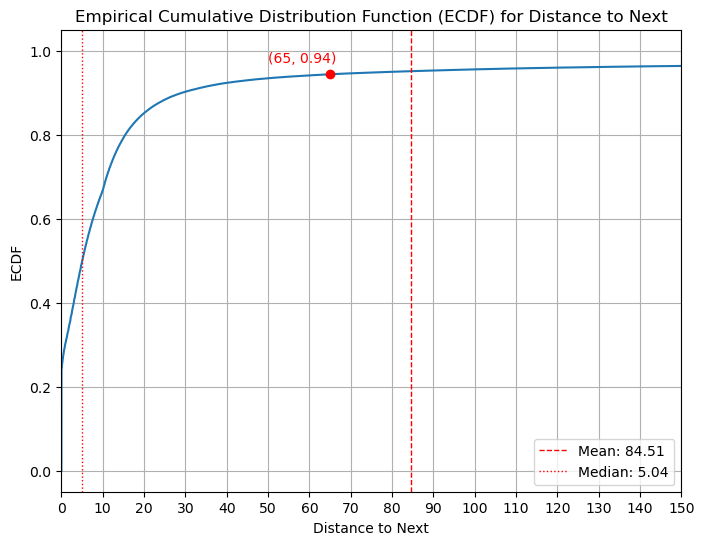

In [184]:
# Sort the data
x = np.sort(check_dist_between_trip_end_and_trip_start['distance_to_next'])

# Calculate ECDF values
y = np.arange(1, len(x)+1) / len(x)

# Plot the ECDF
plt.figure(figsize=(8, 6))
plt.step(x, y, where='post')
plt.xlabel('Distance to Next')
plt.ylabel('ECDF')
plt.title('Empirical Cumulative Distribution Function (ECDF) for Distance to Next')
plt.xticks(np.arange(0, 151, 10))
plt.xlim(0, 150)

# Calculate mean and median
mean_value = check_dist_between_trip_end_and_trip_start['distance_to_next'].mean()
median_value = check_dist_between_trip_end_and_trip_start['distance_to_next'].median()

# Mark the mean and median with vertical lines
plt.axvline(mean_value, color='red', linestyle='--', linewidth=1, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='red', linestyle=':', linewidth=1, label=f'Median: {median_value:.2f}')

# Adding text labels for mean and median
# plt.text(mean_value, 0.1, f'Mean: {mean_value:.2f}', color='red', ha='right')
# plt.text(median_value, 0.3, f'Median: {median_value:.2f}', color='red', ha='right')

# Add a legend
plt.legend()

# Calculate the y-value for x=65
x_value = 65
y_value = np.searchsorted(x, x_value, side='right') / len(x)

# Mark the point for x=30
plt.scatter([x_value], [y_value], color='red', zorder=5)
plt.text(x_value - 15, y_value + 0.02 , f'({x_value}, {y_value:.2f})', color='red', ha='left', va='bottom')

plt.grid(True)
plt.show()

### check each combination - keep from here tommorow!

In [185]:
# Define the conditions for rows to remove
cons_over65_to_remove = (
        ((filtered_df['distance_to_next'] > 65) &
         (filtered_df['event_types'] == 'trip_end') &
         (filtered_df['next_event_types'] == 'provider_drop_off') &
         (filtered_df['vehicle_id'] == filtered_df['next_vehicle_id'])) |
        ((filtered_df['distance_to_next'] > 65) &
         (filtered_df['event_types'] == 'trip_end') &
         (filtered_df['next_event_types'] == 'trip_start') &
         (filtered_df['vehicle_id'] == filtered_df['next_vehicle_id'])) |
        ((filtered_df['distance_to_prev'] > 65) &
         (filtered_df['event_types'] == 'trip_end') &
         (filtered_df['previous_event_types'] == 'provider_drop_off') &
         (filtered_df['vehicle_id'] == filtered_df['previous_vehicle_id']))
    )
cleared_df = filtered_df[~cons_over65_to_remove]
len(cleared_df)

1372220

In [186]:
cleared_df.head(5)

,provider_id,provider_name,vehicle_state,event_types,event_time,device_id,vehicle_id,vehicle_type,propulsion_types,lat,...,time_diff_next,next_state,next_event_types,next_vehicle_id,next_lat,next_lon,time_diff_prev,distance_to_next,distance_to_prev,next_event_time
1551063,0a899e3a-705a-46f2-9189-d78cc83a2db4,Dott,non_operational,battery_low,2025-02-03 14:00:54,6793bc6a-8da1-48b6-a555-973df0b9c6c0,0115,scooter,electric,32.082134000000003,...,-26.0,available,battery_charged,0115,32.082113000000000,34.893500000000003,NaN,4.594610520415486,NaN,2025-02-03 14:01:20
1551068,0a899e3a-705a-46f2-9189-d78cc83a2db4,Dott,available,battery_charged,2025-02-03 14:01:20,6793bc6a-8da1-48b6-a555-973df0b9c6c0,0115,scooter,electric,32.082113000000000,...,-1.0,non_operational,maintenance,0115,32.082113000000000,34.893500000000003,26.0,0.000000000000000,4.594610520415486,2025-02-03 14:01:21
1551069,0a899e3a-705a-46f2-9189-d78cc83a2db4,Dott,non_operational,maintenance,2025-02-03 14:01:21,6793bc6a-8da1-48b6-a555-973df0b9c6c0,0115,scooter,electric,32.082113000000000,...,-529734.0,available,provider_drop_off,0115,32.041477999999998,34.770533999999998,1.0,12437.479270279971388,0.000000000000000,2025-02-09 17:10:15
1612228,0a899e3a-705a-46f2-9189-d78cc83a2db4,Dott,available,provider_drop_off,2025-02-09 17:10:15,6793bc6a-8da1-48b6-a555-973df0b9c6c0,0115,scooter,electric,32.041477999999998,...,-17811.0,removed,maintenance_pick_up,0115,32.041536000000001,34.770474000000000,529734.0,8.577680150682717,12437.479270279971388,2025-02-09 22:07:06
1614447,0a899e3a-705a-46f2-9189-d78cc83a2db4,Dott,removed,maintenance_pick_up,2025-02-09 22:07:06,6793bc6a-8da1-48b6-a555-973df0b9c6c0,0115,scooter,electric,32.041536000000001,...,-8184.0,available,provider_drop_off,0115,32.063507000000001,34.771816999999999,17811.0,2446.340224238653263,8.577680150682717,2025-02-10 00:23:30


## Assign records to parking spots

In [187]:
Parking_Spots_df = pd.read_csv(r'C:\Users\aviyaoh\Downloads\Aviya Ohayon\Parking\Clustered_parking_spots.csv') #Clustered parking spots


In [188]:
Parking_Spots = []
for index, row in Parking_Spots_df.iterrows(): #list
    spot_name = row['spot_name']
    x_value = row['X']
    y_value = row['Y']
    address = row['cluster_address']
    # Append a list to result_list
    Parking_Spots.append([spot_name, x_value, y_value, address])

In [189]:
Parking_Spots

[['Spot 1', 34.786199, 32.07019833333334, 'HaArbaa 28 | Osvaldo Arania 27']]

## ממוזער - למחוק

### Create Polygons

In [190]:
'''
Dizingof_Center_points = [
    (32.075412, 34.775316),
    (32.074403, 34.775622), 
    (32.074738, 34.776154),
    (32.075201, 34.776115)
]

# Create a polygon from the coordinates
Dizingof_Center_polygon = Polygon(Dizingof_Center_points)
'''

'\nDizingof_Center_points = [\n    (32.075412, 34.775316),\n    (32.074403, 34.775622), \n    (32.074738, 34.776154),\n    (32.075201, 34.776115)\n]\n\n# Create a polygon from the coordinates\nDizingof_Center_polygon = Polygon(Dizingof_Center_points)\n'

### check if inside the polygon

In [191]:
'''
from shapely.geometry import Point, Polygon



def is_point_inside_polygon( point_to_check):
    """
    Checks if a given point is inside a polygon.

    Args:
        point_to_check (tuple): Tuple representing the coordinates of the point to check.

    Returns:
        bool: True if the point is inside the polygon, False otherwise.
    """
    point = Point(point_to_check)
    return parking_polygon.contains(point)
'''"0. Translate_Hebrew_GIS_to_English.ipynb"

'\nfrom shapely.geometry import Point, Polygon\n\n\n\ndef is_point_inside_polygon( point_to_check):\n    """\n    Checks if a given point is inside a polygon.\n\n    Args:\n        point_to_check (tuple): Tuple representing the coordinates of the point to check.\n\n    Returns:\n        bool: True if the point is inside the polygon, False otherwise.\n    """\n    point = Point(point_to_check)\n    return parking_polygon.contains(point)\n0. Translate_Hebrew_GIS_to_English.ipynb'

### create parking periods data frame

In [192]:
'''
def find_parking_spots(coord):
    if not is_point_inside_polygon((coord[1], coord[0])):
        return 'not in the polygon', None
    
    # Calculate the bounding box around the parking end point
    bounding_box = {
        'min_lat': coord[1] - 0.0009,  # 0.0009 degrees is approximately 100 meters
        'max_lat': coord[1] + 0.0009,
        'min_lon': coord[0] - 0.0009,
        'max_lon': coord[0] + 0.0009
    }
    
    min_dist = float('inf')
    match_dist = 30  
    nearest_spot = None
    found = False #found parking spot

    for spot in Parking_Spots:
        spot_coord = (spot[2], spot[1])
        
        # Check if the parking spot is inside the bounding box
        if (
            bounding_box['min_lat'] <= spot_coord[0] <= bounding_box['max_lat'] and
            bounding_box['min_lon'] <= spot_coord[1] <= bounding_box['max_lon']
        ):
            dist = haversine(coord[1], coord[0], spot_coord[0], spot_coord[1])
            if dist < min_dist:
                min_dist = dist
            if dist < match_dist:
                found = True
                match_dist = dist
                nearest_spot = spot[0]
    if found:
        return nearest_spot, match_dist
    else: 
        return nearest_spot, min_dist
'''

"\ndef find_parking_spots(coord):\n    if not is_point_inside_polygon((coord[1], coord[0])):\n        return 'not in the polygon', None\n\n    # Calculate the bounding box around the parking end point\n    bounding_box = {\n        'min_lat': coord[1] - 0.0009,  # 0.0009 degrees is approximately 100 meters\n        'max_lat': coord[1] + 0.0009,\n        'min_lon': coord[0] - 0.0009,\n        'max_lon': coord[0] + 0.0009\n    }\n\n    min_dist = float('inf')\n    match_dist = 30  \n    nearest_spot = None\n    found = False #found parking spot\n\n    for spot in Parking_Spots:\n        spot_coord = (spot[2], spot[1])\n\n        # Check if the parking spot is inside the bounding box\n        if (\n            bounding_box['min_lat'] <= spot_coord[0] <= bounding_box['max_lat'] and\n            bounding_box['min_lon'] <= spot_coord[1] <= bounding_box['max_lon']\n        ):\n            dist = haversine(coord[1], coord[0], spot_coord[0], spot_coord[1])\n            if dist < min_dist:\n    

## המשך קוד

In [193]:
import math
import pandas as pd

# 2. Convert parking spots to a list for fast iteration
#    Each item: [spot_name, lon, lat]
parking_spots_list = Parking_Spots_df[['spot_name', 'X', 'Y']].values.tolist()


# 3. Haversine distance in meters between two (lon, lat) points
def haversine_m(lon1, lat1, lon2, lat2):
    """
    Calculate great-circle distance between two points (lon1, lat1) and (lon2, lat2)
    using the Haversine formula. Returns distance in meters.
    """
    R = 6371000  # Earth radius in meters

    # Convert degrees to radians
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    d_phi = math.radians(lat2 - lat1)
    d_lambda = math.radians(lon2 - lon1)

    a = math.sin(d_phi / 2.0) ** 2 + \
        math.cos(phi1) * math.cos(phi2) * math.sin(d_lambda / 2.0) ** 2

    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return R * c  # distance in meters


# 4. Function used by cleared_df['cor'].apply(find_parking_spots)
def find_parking_spots(coord, radius_m=90):
    """
    Given coord = [lon, lat], find the nearest parking spot from parking_spots_list.
    Returns:
        (parking_spot_name, distance_in_meters)
    If the nearest spot is farther than radius_m, parking_spot_name will be None
    but min_dist will still contain the nearest distance (for analysis).
    """
    # coord is a list [lon, lat] as created in cleared_df['cor']
    lon, lat = coord


    # Handle missing coordinates
    if pd.isna(lon) or pd.isna(lat):
        return None, None

    closest_spot_name = None
    closest_dist = float('inf')

    # Iterate over all parking spots and keep the closest one
    for spot_name, spot_lon, spot_lat in parking_spots_list:
        dist = haversine_m(lon, lat, spot_lon, spot_lat)

        if dist < closest_dist:
            closest_dist = dist
            closest_spot_name = spot_name

    # If the nearest parking spot is within the given radius (90m),
    # return its name and distance; otherwise return None and the distance.
    if closest_dist <= radius_m:
        return closest_spot_name, closest_dist
    else:
        return None, closest_dist


# 5. Your existing code – this stays exactly as you wrote it
#    'cor' = [lon, lat] for each row, used as input to find_parking_spots
cleared_df['cor'] = cleared_df.apply(lambda row: [row['lon'], row['lat']], axis=1)

# Apply find_parking_spots to each coordinate and unpack the result into two columns:
# 'parking_spot' = spot_name (or None), 'min_dist' = distance in meters to the nearest spot
cleared_df['parking_spot'], cleared_df['min_dist'] = zip(
    *cleared_df['cor'].apply(find_parking_spots)
)


C:\Users\aviyaoh\AppData\Local\Temp\ipykernel_10316\3959313102.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleared_df['cor'] = cleared_df.apply(lambda row: [row['lon'], row['lat']], axis=1)
C:\Users\aviyaoh\AppData\Local\Temp\ipykernel_10316\3959313102.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleared_df['parking_spot'], cleared_df['min_dist'] = zip(
C:\Users\aviyaoh\AppData\Local\Temp\ipykernel_10316\3959313102.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [194]:
cleared_df['cor'] = cleared_df.apply(lambda row: [row['lon'], row['lat']], axis=1)

C:\Users\aviyaoh\AppData\Local\Temp\ipykernel_10316\2921055224.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleared_df['cor'] = cleared_df.apply(lambda row: [row['lon'], row['lat']], axis=1)


In [195]:
cleared_df['parking_spot'], cleared_df['min_dist'] = zip(*cleared_df['cor'].apply(find_parking_spots))

C:\Users\aviyaoh\AppData\Local\Temp\ipykernel_10316\1207197594.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleared_df['parking_spot'], cleared_df['min_dist'] = zip(*cleared_df['cor'].apply(find_parking_spots))


In [196]:
#merged_clear[merged_clear['parking_spot'] == "Spot 1"]

## FOLIUM MAP EXAMPLE

In [197]:
import folium
from folium.plugins import MarkerCluster

# --- 1. קביעת מרכז המפה (ממוצע הקואורדינטות של האירועים) ---

center_lat = cleared_df['lat'].mean()
center_lon = cleared_df['lon'].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=13)

# --- 2. שכבה לתאי חניה ---

parking_layer = folium.FeatureGroup(name='Parking Spots')

for _, row in Parking_Spots_df.iterrows():
    spot_name = row['spot_name']
    lon = row['X']  # שימי לב: X = lon
    lat = row['Y']  # Y = lat
    
    folium.CircleMarker(
        location=[lat, lon],
        radius=6,
        popup=f"Spot: {spot_name}",
        tooltip=f"Spot: {spot_name}",
        color='blue',
        fill=True,
        fill_opacity=0.8
    ).add_to(parking_layer)

parking_layer.add_to(m)

# --- 3. שכבה לאירועים – מדגימה כדי לא לקרוס (אם יש הרבה שורות) ---

# אם הדאטה ענק, נבחר דגימה כדי שהמפה תהיה קלה
max_points = 5000
if len(cleared_df) > max_points:
    events_df = cleared_df.sample(n=max_points, random_state=42)
else:
    events_df = cleared_df.copy()

events_cluster = MarkerCluster(name='Events (sample)').add_to(m)

for _, row in events_df.iterrows():
    lat = row['lat']
    lon = row['lon']
    min_dist = row['min_dist']
    
    # דילוג על שורות ללא מרחק
    if pd.isna(min_dist):
        continue

    # אירועים בטווח 90 מ' מחניה - ירוקים
    if min_dist <= 90:
        color = 'green'
    else:
        color = 'gray'
    
    folium.CircleMarker(
        location=[lat, lon],
        radius=3,
        popup=f"min_dist: {min_dist:.1f} m",
        tooltip=f"{min_dist:.1f} m",
        color=color,
        fill=True,
        fill_opacity=0.5
    ).add_to(events_cluster)

# --- 4. הוספת כפתור שכבות ושמירת המפה ---

folium.LayerControl().add_to(m)

m.save("parking_events_map.html")
print("מפה נשמרה בשם parking_events_map.html - אפשר לפתוח בדפדפן.")


מפה נשמרה בשם parking_events_map.html - אפשר לפתוח בדפדפן.


In [198]:
import folium

# סינון נקודות שנמצאות בטווח 90 מ'
nearby_df = cleared_df[(cleared_df['min_dist'] <= 90) & (~cleared_df['min_dist'].isna())]

if not nearby_df.empty:
    center_lat2 = nearby_df['lat'].mean()
    center_lon2 = nearby_df['lon'].mean()
else:
    center_lat2 = cleared_df['lat'].mean()
    center_lon2 = cleared_df['lon'].mean()

m_near = folium.Map(location=[center_lat2, center_lon2], zoom_start=16)

# --- תאי חניה (כחול + רדיוס 90מ') ---
parking_layer2 = folium.FeatureGroup(name='Parking Spots')

for _, row in Parking_Spots_df.iterrows():
    spot_name = row['spot_name']
    lon = row['X']  # X = lon
    lat = row['Y']  # Y = lat

    # נקודת תא חניה – יותר גדולה ובולטת
    folium.CircleMarker(
        location=[lat, lon],
        radius=10,              # היה 6 → הגדלנו
        popup=f"Spot: {spot_name}",
        tooltip=f"Spot: {spot_name}",
        color='blue',
        fill=True,
        fill_opacity=1.0
    ).add_to(parking_layer2)

    # עיגול רדיוס 90 מ' סביב תא החניה
    folium.Circle(
        location=[lat, lon],
        radius=90,             # 90 מטר
        color='blue',
        fill=False,
        weight=2,
        opacity=0.7
    ).add_to(parking_layer2)

parking_layer2.add_to(m_near)

# --- אירועים בטווח 90 מ' ---
near_events = folium.FeatureGroup(name='Events within 90m')

for _, row in nearby_df.iterrows():
    lat = row['lat']
    lon = row['lon']
    dist = row['min_dist']
    spot = row['parking_spot']
    etype = row['event_types']   # trip_start / trip_end

    if etype == "trip_start":
        color = 'green'
    elif etype == "trip_end":
        color = 'red'
    else:
        color = 'gray'

    folium.CircleMarker(
        location=[lat, lon],
        radius=5,
        popup=f"Type: {etype}, Spot: {spot}, dist: {dist:.1f} m",
        tooltip=f"{etype} ({dist:.1f} m)",
        color=color,
        fill=True,
        fill_opacity=0.3
    ).add_to(near_events)

near_events.add_to(m_near)

folium.LayerControl().add_to(m_near)

m_near.save("parking_events_within_90m.html")
print("מפה שנייה נשמרה בשם parking_events_within_90m.html")

מפה שנייה נשמרה בשם parking_events_within_90m.html


## המשך קוד

### create duration dataframe

In [199]:
cleared_df = calculate_diffs_and_shifts(cleared_df)
cleared_df['next_event_time'] = cleared_df.groupby('vehicle_id')['event_time'].shift(-1)

In [200]:
merged_clear = cleared_df[['provider_name', 'vehicle_id', 'vehicle_state', 'event_types','event_time',
                           'next_event_types', 'next_event_time', 'source', 'lat', 'lon', 'mds_version', 'parking_spot'
                           ,'min_dist']]

In [201]:
merged_clear.rename(columns={
    'event_types': 'start_event',
    'next_event_type': 'end_event',
    'event_time': 'start_time',
    'next_event_time': 'end_time'
}, inplace=True)

C:\Users\aviyaoh\AppData\Local\Temp\ipykernel_10316\3234203878.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_clear.rename(columns={


In [202]:
print(cleared_df['min_dist'].describe())
print(cleared_df['min_dist'].sort_values().head(20))

count    1.372220000000000e+06
mean     2.274028882868944e+03
std      7.758988376213104e+03
min      2.358667858839470e-01
25%      1.170494523231698e+03
50%      1.811607233702436e+03
75%      2.652094392656893e+03
max      5.103456393808845e+06
Name: min_dist, dtype: float64
1474470    0.235866785883947
1349562    0.240128507818540
1349422    0.240128507818540
1509231    0.265179380060748
1508846    0.386608350291602
1220727    0.398606295964008
1878260    0.449161155881761
2238160    0.449161155881761
2190258    0.449161155881761
2010336    0.449161155881761
2186773    0.490971393778891
2305668    0.517386454596784
1432664    0.565565166100282
1440505    0.565565166100282
1785504    0.566571980387402
1788802    0.566571980387402
1457922    0.594908085728805
1456671    0.594908085728805
2423239    0.623054224785766
1934219    0.673898792685125
Name: min_dist, dtype: float64


In [203]:
spot = Parking_Spots_df[Parking_Spots_df['spot_name']=='Spot 1'].iloc[0]
spot_lon, spot_lat = spot['X'], spot['Y']

merged_clear['dist_to_spot1'] = merged_clear.apply(
    lambda r: haversine_m(r['lon'], r['lat'], spot_lon, spot_lat),
    axis=1
)

merged_clear['dist_to_spot1'].describe()

C:\Users\aviyaoh\AppData\Local\Temp\ipykernel_10316\1484401709.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_clear['dist_to_spot1'] = merged_clear.apply(


count    1.372220000000000e+06
mean     2.274028882868944e+03
std      7.758988376213104e+03
min      2.358667858839470e-01
25%      1.170494523231698e+03
50%      1.811607233702436e+03
75%      2.652094392656893e+03
max      5.103456393808845e+06
Name: dist_to_spot1, dtype: float64

In [204]:
# Final Adjustments

# 1. Make sure start_time and end_time are datetime
merged_clear['start_time'] = pd.to_datetime(merged_clear['start_time'])
merged_clear['end_time']   = pd.to_datetime(merged_clear['end_time'])

# 2. Create duration column (trip duration in seconds)
merged_clear['duration'] = (merged_clear['end_time'] - merged_clear['start_time']).dt.total_seconds()

# 3. Rename 'start_event' -> 'event_types'
merged_clear = merged_clear.rename(columns={'start_event': 'event_types'})

# 4. Drop the 'mds_version' column
merged_clear = merged_clear.drop(columns=['mds_version', 'dist_to_spot1', 'min_dist'])


C:\Users\aviyaoh\AppData\Local\Temp\ipykernel_10316\297892690.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_clear['start_time'] = pd.to_datetime(merged_clear['start_time'])
C:\Users\aviyaoh\AppData\Local\Temp\ipykernel_10316\297892690.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_clear['end_time']   = pd.to_datetime(merged_clear['end_time'])
C:\Users\aviyaoh\AppData\Local\Temp\ipykernel_10316\297892690.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [205]:
pd.set_option('display.max_colwidth', None)
merged_clear.head(5)

,provider_name,vehicle_id,vehicle_state,event_types,start_time,next_event_types,end_time,source,lat,lon,parking_spot,duration
1551063,Dott,0115,non_operational,battery_low,2025-02-03 14:00:54,battery_charged,2025-02-03 14:01:20,status_changes,32.082134000000003,34.893458000000003,None,26.0
1551068,Dott,0115,available,battery_charged,2025-02-03 14:01:20,maintenance,2025-02-03 14:01:21,status_changes,32.082113000000000,34.893500000000003,None,1.0
1551069,Dott,0115,non_operational,maintenance,2025-02-03 14:01:21,provider_drop_off,2025-02-09 17:10:15,status_changes,32.082113000000000,34.893500000000003,None,529734.0
1612228,Dott,0115,available,provider_drop_off,2025-02-09 17:10:15,maintenance_pick_up,2025-02-09 22:07:06,status_changes,32.041477999999998,34.770533999999998,None,17811.0
1614447,Dott,0115,removed,maintenance_pick_up,2025-02-09 22:07:06,provider_drop_off,2025-02-10 00:23:30,status_changes,32.041536000000001,34.770474000000000,None,8184.0


In [206]:
# print(merged_clear['parking_spot'].notna().sum())
# merged_clear[merged_clear['parking_spot'].notna()].head()

# print all rows with not null "parking spots"
print(merged_clear['parking_spot'].notna().sum())

7081


In [207]:
# save as csv all rows with assiged parking spot 
merged_clear[merged_clear['parking_spot'].notna()].to_csv(r'C:\Users\aviyaoh\Downloads\Aviya Ohayon\Clean Data\Assign to Parking Lots Data\2025-02_Assign to parkinglot_Final_Status.csv', index=False)

# save as csv all clean data 
merged_clear.to_csv(r'C:\Users\aviyaoh\Downloads\Aviya Ohayon\Clean Data\Full clean data\2025-02_Full_Final_Status.csv', index=False)
